In [1]:
import os
import sys
#
import tensorflow as tf
# limit gpu mem
#gpus = tf.config.list_physical_devices('GPU')
#tf.config.set_logical_device_configuration(gpus[0],[tf.config.LogicalDeviceConfiguration(memory_limit=3700)])
#
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
logical_gpus = tf.config.list_logical_devices('GPU')
print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#
import matplotlib.pyplot as plt
from datetime import datetime
from tensorflow.keras.layers import (
    Activation, AveragePooling2D, BatchNormalization, Conv2D, add, Conv2DTranspose,
    Dense, Dropout, Flatten, Input, LeakyReLU, ReLU, UpSampling2D)
from tensorflow.keras.models import Sequential, Model
#from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
#from tfa.layers.InstanceNormalization import InstanceNormalization
from time import time

import numpy as np
import cv2
import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from tensorflow.keras import Input
#from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import Conv2D
#
from matplotlib import pyplot
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import load_img,save_img
#from keras.utils.vis_utils import plot_model
from copy import deepcopy

from skimage.color import rgb2lab, lab2rgb, rgb2hsv, hsv2rgb
from PIL import Image

convstride=np.array([[[3,3],[1,1]],[[3,3],[2,2]],[[3,3],[2,2]],[[3,3],[2,2]],[[3,3],[2,2]],[[3,3],[2,2]]])
convstride_dis=np.array([[[3,3],[2,2]],[[3,3],[2,2]],[[3,3],[2,2]],[[3,3],[2,2]],[[3,3],[2,2]],[[3,3],[2,2]]])

2023-09-20 16:42:52.156325: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-20 16:42:53.384899: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-09-20 16:42:54.775162: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-20 16:42:55.081111: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

1 Physical GPUs, 1 Logical GPUs


In [2]:
# conversion lab & rgb
def lab_to_rgb(img_lab):
    img_lab = img_lab.numpy()
    L = (img_lab[:,:,:,0] + 1.) * 50. 
    L = L[..., np.newaxis]
    ab = img_lab[:,:,:,1:]  * 110
    img_lab = np.concatenate((L,ab),axis=3)
    #
    img = lab2rgb(img_lab).astype("float32")
    img = (img * 255).astype(np.uint8)
    return img

def rgb_to_lab(img):
    img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b    # float16 to optimize ?
    # Between -1 and 1
    L  = img_lab[:,:,0]  / 50. - 1. 
    ab = img_lab[:,:,1:]  / 110. # Between -1 and 1 
    return L, ab

**MODEL**

In [3]:
#def InstanceNormalization(g): 
#    return BatchNormalization(axis=[0,1])(g)

def Rk(input_layer, n_filters):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # first layer convolutional layer
    g = tf.pad(input_layer, [[0, 0], [1, 1], [1, 1], [0, 0]], "REFLECT")
    g = Conv2D(n_filters, (3,3), padding='valid', kernel_initializer=init)(g)
    g = BatchNormalization()(g, training=True)  #InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # second convolutional layer
    g = tf.pad(g, [[0, 0], [1, 1], [1, 1], [0, 0]], "REFLECT")
    g = Conv2D(n_filters, (3,3), padding='valid', kernel_initializer=init)(g)
    g = BatchNormalization()(g, training=True)
    # concatenate merge channel-wise with input layer
    return g + input_layer

# define the standalone generator model
def define_generator(image_shape, n_resnet=9):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_shape)
    # c7s1-64
    g = tf.pad(in_image, [[0, 0], [2, 2], [2, 2], [0, 0]], "REFLECT")
    g = Conv2D(64, (5,5), padding='valid', kernel_initializer=init)(g)
    g = BatchNormalization()(g, training=True)
    g = Activation('relu')(g)
    ## d64
    #g = Conv2D(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    #g = BatchNormalization()(g, training=True)
    #g = Activation('relu')(g)
    # d128
    g = tf.pad(g, [[0, 0], [1, 1], [1, 1], [0, 0]], "REFLECT")
    g = Conv2D(128, (3,3), strides=(2,2), padding='valid', kernel_initializer=init)(g)
    g = BatchNormalization()(g, training=True)
    g = Activation('relu')(g)
    # d256
    g = tf.pad(g, [[0, 0], [1, 1], [1, 1], [0, 0]], "REFLECT")
    g = Conv2D(256, (3,3), strides=(2,2), padding='valid', kernel_initializer=init)(g)
    g = BatchNormalization()(g, training=True)
    g = Activation('relu')(g)
    # R256
    for _ in range(n_resnet):
        g = Rk(g, 256)
    # u128 
    g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = BatchNormalization()(g, training=True)
    g = Activation('relu')(g)
    # u64 
    g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = BatchNormalization()(g, training=True)
    g = Activation('relu')(g)
    ## u32 64
    #g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    #g = BatchNormalization()(g, training=True)
    #g = Activation('relu')(g)
    # c7s1-3
    g = tf.pad(g, [[0, 0], [2, 2], [2, 2], [0, 0]], "REFLECT")
    g = Conv2D(3, (5,5), padding='valid', kernel_initializer=init)(g)
    g = BatchNormalization()(g, training=True)
    #out_image = Activation('tanh')(g)
    out_image = Activation('tanh')(g)
    # define model
    model = Model(in_image, out_image)
    model.summary()
    return model


# define the discriminator model
def define_discriminator(image_shape):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # source image input
    in_image = Input(shape=image_shape)
    # C64
    d = Conv2D(42, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    d = LeakyReLU(alpha=0.2)(d)
    # C128
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d, training=True)
    d = LeakyReLU(alpha=0.2)(d)
    # C256
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d, training=True)
    d = LeakyReLU(alpha=0.2)(d)
    # C512
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d, training=True)
    d = LeakyReLU(alpha=0.2)(d)
    # second last output layer
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d, training=True)
    d = LeakyReLU(alpha=0.2)(d)
    # patch output
    patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    # define model
    model = Model(in_image, patch_out)
    model.summary()
    return model

**LOSS**

In [4]:
LAMBDA = 12 #10
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(disc_real_output, disc_generated_output):
    #d_loss_A = (tf.reduce_mean(tf.square(self.fake_pool_rec_A)) + tf.reduce_mean(tf.squared_difference(self.rec_A,1)))/2.0
    #d_loss_B = (tf.reduce_mean(tf.square(self.fake_pool_rec_B)) + tf.reduce_mean(tf.squared_difference(self.rec_B,1)))/2.0
    #
    real_loss = tf.reduce_mean(tf.math.squared_difference(tf.ones_like(disc_real_output), disc_real_output)) / 2.0
    generated_loss = tf.reduce_mean(tf.square(disc_generated_output)) / 2.0
    
    #generated_loss = cross_entropy(tf.zeros_like(disc_generated_output), disc_generated_output)
    #real_loss = cross_entropy(tf.ones_like(disc_real_output), disc_real_output)
    
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    #loss = tf.reduce_mean(tf.square(real_image - same_image))
    return LAMBDA * 0.5 * loss

def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    #loss1 = tf.reduce_mean(tf.square(real_image - cycled_image))
    return LAMBDA * loss1

def gan_loss(disc_generated_A):
    gan_loss = tf.reduce_mean(tf.math.squared_difference(tf.ones_like(disc_generated_A), disc_generated_A))
    #gan_loss = cross_entropy(tf.ones_like(disc_generated_A), disc_generated_A)
    return gan_loss

def GEN_total_loss(GEN_X, GEN_Y, im_X, im_Y, gen_output_X_Y_bar, gen_output_Y_X_bar, disc_generated_X, disc_generated_Y ):
    id_X_loss = identity_loss(im_Y, GEN_X(im_Y))
    id_Y_loss = identity_loss(im_X, GEN_Y(im_X))
            
    cycle_X_loss= calc_cycle_loss(gen_output_Y_X_bar, im_X)
    cycle_Y_loss= calc_cycle_loss(gen_output_X_Y_bar, im_Y)
    cycle_total_loss = cycle_X_loss + cycle_Y_loss
            
    gan_X_loss = gan_loss(disc_generated_Y)
    gan_Y_loss = gan_loss(disc_generated_X)
    
    total_X = gan_X_loss + cycle_total_loss + id_X_loss
    total_Y = gan_Y_loss + cycle_total_loss + id_Y_loss
    
    return total_X, total_Y
    
# old loss
def generator_loss(disc_generated_A, gen_output_A_B_bar, img_B):
    gan_loss = cross_entropy(tf.ones_like(disc_generated_A), disc_generated_A)
    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(gen_output_A_B_bar - img_B))
    #
    total_gen_loss = gan_loss + (LAMBDA*l1_loss)
    return total_gen_loss, gan_loss, l1_loss

In [5]:
GEN_X = define_generator(image_shape=(256,256,3), n_resnet=9)
DISC_X = define_discriminator(image_shape=(256,256,3))

GEN_X_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)    #2e-4
DISC_X_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)  #2e-4

GEN_Y = define_generator(image_shape=(256,256,3), n_resnet=9)
DISC_Y = define_discriminator(image_shape=(256,256,3))

GEN_Y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)    #2e-4
DISC_Y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)  #2e-4

/home/anton/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 tf.compat.v1.pad (TFOpLamb  (None, 260, 260, 3)          0         ['input_1[0][0]']             
 da)                                                                                              
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         4864      ['tf.compat.v1.pad[0][0]']    
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']          

 mbda)                                                              ']                            
                                                                                                  
 conv2d_7 (Conv2D)           (None, 64, 64, 256)          590080    ['tf.compat.v1.pad_7[0][0]']  
                                                                                                  
 batch_normalization_7 (Bat  (None, 64, 64, 256)          1024      ['conv2d_7[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation_5 (Activation)   (None, 64, 64, 256)          0         ['batch_normalization_7[0][0]'
                                                                    ]                             
                                                                                                  
 tf.compat

                                                                                                  
 conv2d_14 (Conv2D)          (None, 64, 64, 256)          590080    ['tf.compat.v1.pad_14[0][0]'] 
                                                                                                  
 batch_normalization_14 (Ba  (None, 64, 64, 256)          1024      ['conv2d_14[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 tf.__operators__.add_5 (TF  (None, 64, 64, 256)          0         ['batch_normalization_14[0][0]
 OpLambda)                                                          ',                            
                                                                     'tf.__operators__.add_4[0][0]
                                                                    ']                            
          

 conv2d_transpose (Conv2DTr  (None, 128, 128, 128)        295040    ['tf.__operators__.add_8[0][0]
 anspose)                                                           ']                            
                                                                                                  
 batch_normalization_21 (Ba  (None, 128, 128, 128)        512       ['conv2d_transpose[0][0]']    
 tchNormalization)                                                                                
                                                                                                  
 activation_12 (Activation)  (None, 128, 128, 128)        0         ['batch_normalization_21[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_transpose_1 (Conv2D  (None, 256, 256, 64)         73792     ['activation_12[0][0]']       
 Transpose

 tchNormalization)                                                                                
                                                                                                  
 activation_16 (Activation)  (None, 128, 128, 128)        0         ['batch_normalization_29[0][0]
                                                                    ']                            
                                                                                                  
 tf.compat.v1.pad_24 (TFOpL  (None, 130, 130, 128)        0         ['activation_16[0][0]']       
 ambda)                                                                                           
                                                                                                  
 conv2d_30 (Conv2D)          (None, 64, 64, 256)          295168    ['tf.compat.v1.pad_24[0][0]'] 
                                                                                                  
 batch_nor

 FOpLambda)                                                         ',                            
                                                                     'tf.__operators__.add_10[0][0
                                                                    ]']                           
                                                                                                  
 tf.compat.v1.pad_31 (TFOpL  (None, 66, 66, 256)          0         ['tf.__operators__.add_11[0][0
 ambda)                                                             ]']                           
                                                                                                  
 conv2d_37 (Conv2D)          (None, 64, 64, 256)          590080    ['tf.compat.v1.pad_31[0][0]'] 
                                                                                                  
 batch_normalization_37 (Ba  (None, 64, 64, 256)          1024      ['conv2d_37[0][0]']           
 tchNormal

                                                                                                  
 activation_24 (Activation)  (None, 64, 64, 256)          0         ['batch_normalization_43[0][0]
                                                                    ']                            
                                                                                                  
 tf.compat.v1.pad_38 (TFOpL  (None, 66, 66, 256)          0         ['activation_24[0][0]']       
 ambda)                                                                                           
                                                                                                  
 conv2d_44 (Conv2D)          (None, 64, 64, 256)          590080    ['tf.compat.v1.pad_38[0][0]'] 
                                                                                                  
 batch_normalization_44 (Ba  (None, 64, 64, 256)          1024      ['conv2d_44[0][0]']           
 tchNormal

 tf.compat.v1.pad_43 (TFOpL  (None, 260, 260, 64)         0         ['activation_28[0][0]']       
 ambda)                                                                                           
                                                                                                  
 conv2d_49 (Conv2D)          (None, 256, 256, 3)          4803      ['tf.compat.v1.pad_43[0][0]'] 
                                                                                                  
 batch_normalization_51 (Ba  (None, 256, 256, 3)          12        ['conv2d_49[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_29 (Activation)  (None, 256, 256, 3)          0         ['batch_normalization_51[0][0]
                                                                    ']                            
          

**UTILS**

In [6]:
# plot real source images
def summarize_performance(step, img_X_B, img_X_Y, img_Y_B, img_Y_X):
    X_B = (img_X_B[-1] +1.0) / 2.0   # -1
    X_Y = (img_X_Y[0] +1.0 ) / 2.0   
    Y_B = (img_Y_B[-1] +1.0) / 2.0   # -1
    Y_X = (img_Y_X[0] + 1.0) / 2.0
    #test = img_X_B[-1].numpy()
    #print(test[:3,:3])
    pyplot.subplot(2, 2, 1)
    pyplot.axis('off')       
    pyplot.imshow(X_B)   #*255
    pyplot.title('X org')
    
    pyplot.subplot(2, 2, 2)
    pyplot.axis('off')       
    pyplot.imshow(X_Y) 
    pyplot.title('X org -> Y')

    pyplot.subplot(2, 2, 3)
    pyplot.axis('off')       
    pyplot.imshow(Y_B)  #*255   
    pyplot.title('Y org')

    pyplot.subplot(2, 2, 4)
    pyplot.axis('off')       
    pyplot.imshow(Y_X) 
    pyplot.title('Y org -> X')

    # save plot to file
    filename1 = 'plot_%06d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()

def test_loss_avg(GEN_X, DISC_Y,path):
    Loss_avg = list()
    #L1_avg = list()

    IMAGE=os.listdir(path)
    IMAGE.sort()
    
    for file_img in IMAGE:
        print(file_img)
        new_im = os.path.join(path,file_img)

        # now read the input image files (difference from the code it is derived from that preloads all images)
        pixels = Image.open(new_im).convert("RGB")
        pixels = np.array(pixels)
        pixels = pixels[np.newaxis, ...]
        #
        img_Y_fake = GEN_X(pixels, training=False)
        #
        disc_on_test = DISC_Y(img_Y_fake,training=False)
        #
        test_loss, gan_loss, l1_loss=generator_loss(disc_on_test, img_Y_fake, pixels)
        Loss_avg.append(test_loss)
        #L1_avg.append(l1_loss)
        
    avg = np.mean(Loss_avg) 
    #l1 = np.mean(L1_avg)
    return avg

def shuffle_and_batch(Dataset, buff_size, SEED):
    # SHUFFLE
    Dataset_S = Dataset.shuffle(buffer_size = buff_size,seed=SEED)    #10 * BATCH_SIZE   L_dataset.cardinality()
    # Batch
    Dataset_B = Dataset_S.batch(BATCH_SIZE)
    return(Dataset_B)

def change_Bright(image,B):        #run_eagerly=True   ???
    img = rgb2hsv(image[0:1]*127.5 + 127.5)
    img[:,:,:,2] = np.clip(img[:,:,:,2]*B,0,255)
    img = (hsv2rgb(img) - 127.5) / 127.5
    img_final = tf.keras.layers.concatenate([img, image[1:]],axis=0)
    return img_final

In [7]:
# GEN_X -->  Generator from X to Y
# DISC_X --> Discriminator of X images
# ...

@tf.function
def train_step(GEN_X, DISC_X, GEN_Y, DISC_Y, img_X, img_Y, batch):    #input image : L (480,640,1)  && target : Lab image (480,640,2)
    GLX=DLX= tf.constant(0.)
    GLY=DLY= tf.constant(0.)
    # for each image of the batch
    with tf.GradientTape() as genX_tape, tf.GradientTape() as discX_tape, tf.GradientTape() as genY_tape, tf.GradientTape() as discY_tape:
        for i in range(batch):
            #  X --> Y --> X_bar  #
            gen_output_X_Y = GEN_X(img_X[i:i+1], training=True)
            gen_output_Y_X_bar = GEN_Y(gen_output_X_Y, training=True)
            #  Y --> X --> Y_bar  #
            gen_output_Y_X = GEN_Y(img_Y[i:i+1], training=True)
            gen_output_X_Y_bar = GEN_X(gen_output_Y_X, training=True)
            #
            #  DISCRIMINATOR generated losses  #
            disc_generated_X = DISC_X(gen_output_Y_X , training=True)
            disc_generated_Y = DISC_Y(gen_output_X_Y, training=True)
            #  DISCRIMINATOR Real losses  #
            disc_real_X = DISC_X(img_X[i:i+1], training=True)
            disc_real_Y = DISC_Y(img_Y[i:i+1], training=True)
            #  DISCRIMINATOR total losses  #
            disc_loss_X = discriminator_loss(disc_real_X, disc_generated_X)
            disc_loss_Y = discriminator_loss(disc_real_Y, disc_generated_Y)
            #
            # GENERATOR #
            #id_X_loss = identity_loss(img_Y[i:i+1], GEN_X(img_Y[i:i+1]))
            #id_Y_loss = identity_loss(img_X[i:i+1], GEN_Y(img_X[i:i+1]))
            
            #cycle_X_loss= calc_cycle_loss(gen_output_Y_X_bar, img_X[i:i+1])
            #cycle_Y_loss= calc_cycle_loss(gen_output_X_Y_bar, img_Y[i:i+1])
            #cycle_total_loss = cycle_X_loss + cycle_Y_loss
            
            #gan_X_loss = gan_loss(disc_generated_Y)
            #gan_Y_loss = gan_loss(disc_generated_X)
            
            #gen_total_loss_X = gan_X_loss+ cycle_total_loss +id_X_loss
            #gen_total_loss_Y = gan_Y_loss+ cycle_total_loss +id_Y_loss
            
            gen_total_loss_X, gen_total_loss_Y = GEN_total_loss(GEN_X, GEN_Y, img_X[i:i+1], img_Y[i:i+1], gen_output_X_Y_bar, gen_output_Y_X_bar, disc_generated_X, disc_generated_Y)
            
            DLX=tf.add(DLX,disc_loss_X)
            GLX=tf.add(GLX,gen_total_loss_X)
            DLY=tf.add(DLY,disc_loss_Y)
            GLY=tf.add(GLY,gen_total_loss_Y)
            
            #print("ok3")

        # mean of batch loss
        DLX = tf.math.divide(DLX,batch)
        GLX = tf.math.divide(GLX,batch)
        DLY = tf.math.divide(DLY,batch)
        GLY = tf.math.divide(GLY,batch)
        
        # Update at the end of batch
        generator_gradients_X = genX_tape.gradient(GLX,
                                                GEN_X.trainable_variables)
        discriminator_gradients_X = discX_tape.gradient(DLX,
                                                     DISC_X.trainable_variables)
        GEN_X_optimizer.apply_gradients(zip(generator_gradients_X,
                                              GEN_X.trainable_variables))
        DISC_X_optimizer.apply_gradients(zip(discriminator_gradients_X,
                                                  DISC_X.trainable_variables))
        
        generator_gradients_Y = genY_tape.gradient(GLY,
                                                GEN_Y.trainable_variables)
        discriminator_gradients_Y = discY_tape.gradient(DLY,
                                                     DISC_Y.trainable_variables)
        GEN_Y_optimizer.apply_gradients(zip(generator_gradients_Y,
                                              GEN_Y.trainable_variables))
        DISC_Y_optimizer.apply_gradients(zip(discriminator_gradients_Y,
                                                  DISC_Y.trainable_variables))

    return GLX, DLX, GLY, DLY, gen_output_X_Y, gen_output_Y_X


# train pix2pix models
def train(GEN_X, DISC_X, GEN_Y, DISC_Y, dataset, batch=4):
    # determine the output square shape of the discriminator
    n_patch1 = DISC_X.output_shape[1]
    n_patch2 = DISC_X.output_shape[2]
    # calculate the number of batches per training epoch
    #
    GLoss = []
    DLoss = []
    i=0
    # manually enumerate batch
    for data in dataset:
        img_X = data[:,:,:,:3]
        img_Y = data[:,:,:,3:]
        # BRIGHT +/-
        bright = np.clip(np.random.normal(0.9,0.2),0.7,1.1)     #0.9,0.2
        img_X_B = change_Bright(img_X,bright)
        img_Y_B = change_Bright(img_Y,bright)
        # train step, update loss, gradient
        gen_loss_X, disc_loss_X, gen_loss_Y, disc_loss_Y, img_X_Y, img_Y_X = train_step(GEN_X, DISC_X, GEN_Y, DISC_Y, img_X_B, img_Y_B, batch)    # tf.constant()
        #
        print("step "+str(i)+" gen_loss : "+str(gen_loss_X.numpy())+" disc_loss : "+str(disc_loss_X.numpy())+" Bright coef : "+str(bright))
        GLoss.append(gen_loss_X.numpy())
        DLoss.append(disc_loss_X.numpy())
        # summarize model performance every 200 steps
        if (i % 50 == 0) and (i !=0):
            summarize_performance(i, img_X_B, img_X_Y, img_Y_B, img_Y_X)
        i+=1
    return(DLoss, GLoss, GEN_X, DISC_X, GEN_Y, DISC_Y)


/home/anton/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


/home/anton/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


/home/anton/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Learning Rate G : 0.0002 Learning Rate D : 0.0002
Seed :  8339

Start of epoch 15


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 13102495060129563399
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 13102495060129563399
2023-09-20 16:43:45.054226: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuD

step 0 gen_loss : 9.641927 disc_loss : 0.045530412 Bright coef : 0.7
step 1 gen_loss : 7.7273226 disc_loss : 0.105879195 Bright coef : 0.9390326727905085
step 2 gen_loss : 6.3349586 disc_loss : 0.19660655 Bright coef : 1.1
step 3 gen_loss : 6.889241 disc_loss : 0.1010275 Bright coef : 0.7
step 4 gen_loss : 6.565234 disc_loss : 0.016408471 Bright coef : 1.0206005324196674
step 5 gen_loss : 7.905534 disc_loss : 0.011396004 Bright coef : 1.1
step 6 gen_loss : 6.4513373 disc_loss : 0.010161376 Bright coef : 0.7
step 7 gen_loss : 5.137721 disc_loss : 0.056631304 Bright coef : 0.8358007392716031
step 8 gen_loss : 6.576252 disc_loss : 0.12529589 Bright coef : 1.1
step 9 gen_loss : 6.2040467 disc_loss : 0.23394194 Bright coef : 0.7
step 10 gen_loss : 4.406376 disc_loss : 0.054878466 Bright coef : 0.8428112766841791
step 11 gen_loss : 6.337682 disc_loss : 0.05585727 Bright coef : 0.7777353169936977
step 12 gen_loss : 6.6494474 disc_loss : 0.093182735 Bright coef : 1.1
step 13 gen_loss : 6.30602

step 105 gen_loss : 5.8697886 disc_loss : 0.050831296 Bright coef : 0.9534623298682847
step 106 gen_loss : 8.818079 disc_loss : 0.1695291 Bright coef : 0.7
step 107 gen_loss : 8.013852 disc_loss : 0.051649265 Bright coef : 0.7485120672203525
step 108 gen_loss : 4.6632853 disc_loss : 0.18975973 Bright coef : 1.1
step 109 gen_loss : 7.1660805 disc_loss : 0.029215032 Bright coef : 0.9206465821223863
step 110 gen_loss : 6.119322 disc_loss : 0.0743261 Bright coef : 1.1
step 111 gen_loss : 5.977668 disc_loss : 0.059949897 Bright coef : 0.929133356244829
step 112 gen_loss : 6.035084 disc_loss : 0.06762392 Bright coef : 0.7295013840564728
step 113 gen_loss : 10.204269 disc_loss : 0.08596062 Bright coef : 1.1
step 114 gen_loss : 6.804901 disc_loss : 0.037939735 Bright coef : 0.8639837082873717
step 115 gen_loss : 6.999497 disc_loss : 0.022344079 Bright coef : 0.7
step 116 gen_loss : 6.3221326 disc_loss : 0.101204365 Bright coef : 0.7
step 117 gen_loss : 5.8853106 disc_loss : 0.04187947 Bright c

step 206 gen_loss : 5.2298837 disc_loss : 0.14739686 Bright coef : 0.9895154041392864
step 207 gen_loss : 4.78184 disc_loss : 0.065423176 Bright coef : 1.0924247402283769
step 208 gen_loss : 5.0553565 disc_loss : 0.01891131 Bright coef : 0.9515185223912193
step 209 gen_loss : 4.8452682 disc_loss : 0.022286085 Bright coef : 0.9796665856460063
step 210 gen_loss : 4.664576 disc_loss : 0.2317708 Bright coef : 0.898213925693096
step 211 gen_loss : 6.839401 disc_loss : 0.08460336 Bright coef : 0.8348662543935726
step 212 gen_loss : 6.2466044 disc_loss : 0.16235688 Bright coef : 1.1
step 213 gen_loss : 6.151259 disc_loss : 0.22201166 Bright coef : 0.9541776091928733
step 214 gen_loss : 5.748881 disc_loss : 0.1647427 Bright coef : 1.0722917435505257
step 215 gen_loss : 5.350357 disc_loss : 0.1518809 Bright coef : 0.7
step 216 gen_loss : 5.920786 disc_loss : 0.10581243 Bright coef : 0.7392576655941757
step 217 gen_loss : 7.8643465 disc_loss : 0.053429022 Bright coef : 0.9945940178810034
step 21

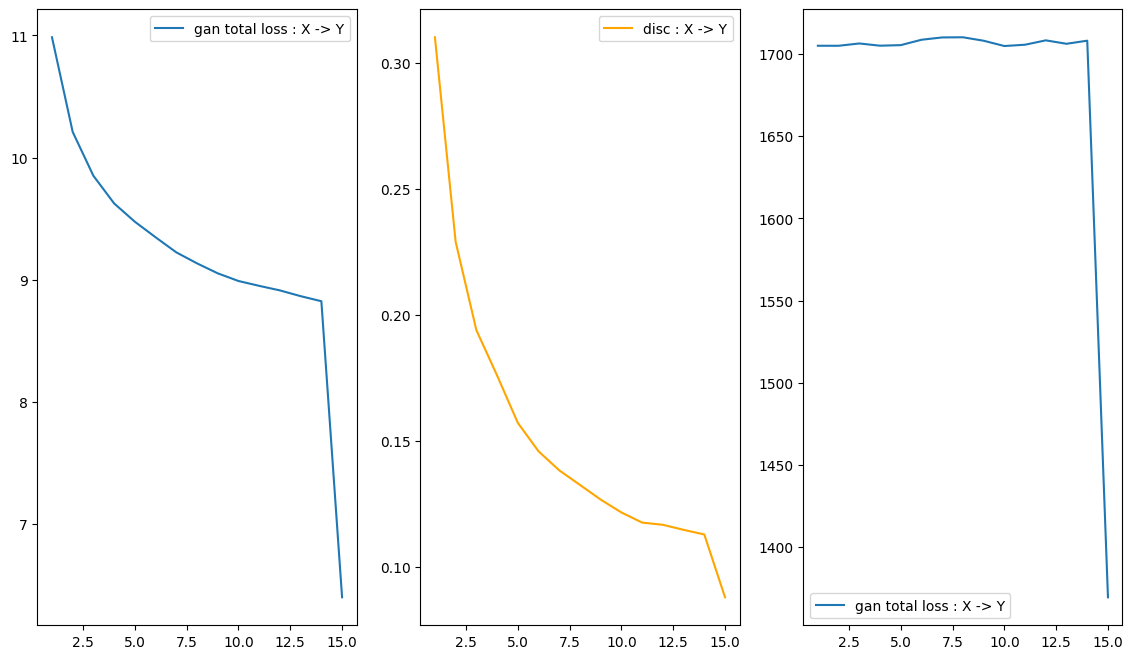

Seed :  3129

Start of epoch 16


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 13102495060129563399


step 0 gen_loss : 6.4595904 disc_loss : 0.18390018 Bright coef : 0.7
step 1 gen_loss : 8.662818 disc_loss : 0.039143424 Bright coef : 0.7
step 2 gen_loss : 5.3186126 disc_loss : 0.030888205 Bright coef : 0.7
step 3 gen_loss : 5.9941845 disc_loss : 0.024630785 Bright coef : 1.073973598252897
step 4 gen_loss : 9.960986 disc_loss : 0.024587734 Bright coef : 1.1
step 5 gen_loss : 5.2120647 disc_loss : 0.0672802 Bright coef : 0.9368623998163677
step 6 gen_loss : 4.373566 disc_loss : 0.015494503 Bright coef : 0.8034953826994978
step 7 gen_loss : 9.189748 disc_loss : 0.058952205 Bright coef : 1.1
step 8 gen_loss : 6.2893796 disc_loss : 0.086727 Bright coef : 0.8658248215550638
step 9 gen_loss : 7.204499 disc_loss : 0.026841003 Bright coef : 1.1
step 10 gen_loss : 9.082057 disc_loss : 0.06703063 Bright coef : 0.9806466251776894
step 11 gen_loss : 6.983085 disc_loss : 0.13941085 Bright coef : 0.7212538871016275
step 12 gen_loss : 8.717572 disc_loss : 0.09209654 Bright coef : 1.1
step 13 gen_los

step 103 gen_loss : 9.323983 disc_loss : 0.18769753 Bright coef : 1.1
step 104 gen_loss : 4.7146993 disc_loss : 0.056988545 Bright coef : 0.8489544989861517
step 105 gen_loss : 8.995802 disc_loss : 0.122253805 Bright coef : 0.7027508424098875
step 106 gen_loss : 6.18293 disc_loss : 0.22465861 Bright coef : 0.9615871841143347
step 107 gen_loss : 7.7000294 disc_loss : 0.0739396 Bright coef : 0.7106278060404158
step 108 gen_loss : 7.2229066 disc_loss : 0.060785584 Bright coef : 1.0726700552382746
step 109 gen_loss : 5.6355586 disc_loss : 0.06981364 Bright coef : 1.1
step 110 gen_loss : 8.435248 disc_loss : 0.04979124 Bright coef : 0.7
step 111 gen_loss : 7.2763906 disc_loss : 0.043567732 Bright coef : 1.0207461552618668
step 112 gen_loss : 7.023449 disc_loss : 0.035489023 Bright coef : 0.9961787754971316
step 113 gen_loss : 5.007784 disc_loss : 0.1368758 Bright coef : 0.9270704475218317
step 114 gen_loss : 6.4292307 disc_loss : 0.1376636 Bright coef : 0.9010071628866997
step 115 gen_loss 

step 204 gen_loss : 7.490639 disc_loss : 0.11922036 Bright coef : 0.7
step 205 gen_loss : 6.9458027 disc_loss : 0.16349086 Bright coef : 0.7816470128746702
step 206 gen_loss : 6.7404113 disc_loss : 0.11955027 Bright coef : 0.9652572534656626
step 207 gen_loss : 8.24033 disc_loss : 0.13479665 Bright coef : 0.7
step 208 gen_loss : 5.811055 disc_loss : 0.03825665 Bright coef : 0.8435197204493173
step 209 gen_loss : 6.847715 disc_loss : 0.017009942 Bright coef : 0.7
step 210 gen_loss : 9.215269 disc_loss : 0.024969269 Bright coef : 0.8785323704842696
step 211 gen_loss : 6.2018805 disc_loss : 0.11927819 Bright coef : 1.1
step 212 gen_loss : 5.6780405 disc_loss : 0.029222567 Bright coef : 0.7611447542023546
step 213 gen_loss : 6.0916734 disc_loss : 0.027184986 Bright coef : 0.7954639920775406
step 214 gen_loss : 6.3983526 disc_loss : 0.093355566 Bright coef : 1.1
step 215 gen_loss : 9.1278 disc_loss : 0.048001282 Bright coef : 1.059138005650467
step 216 gen_loss : 9.644381 disc_loss : 0.1288

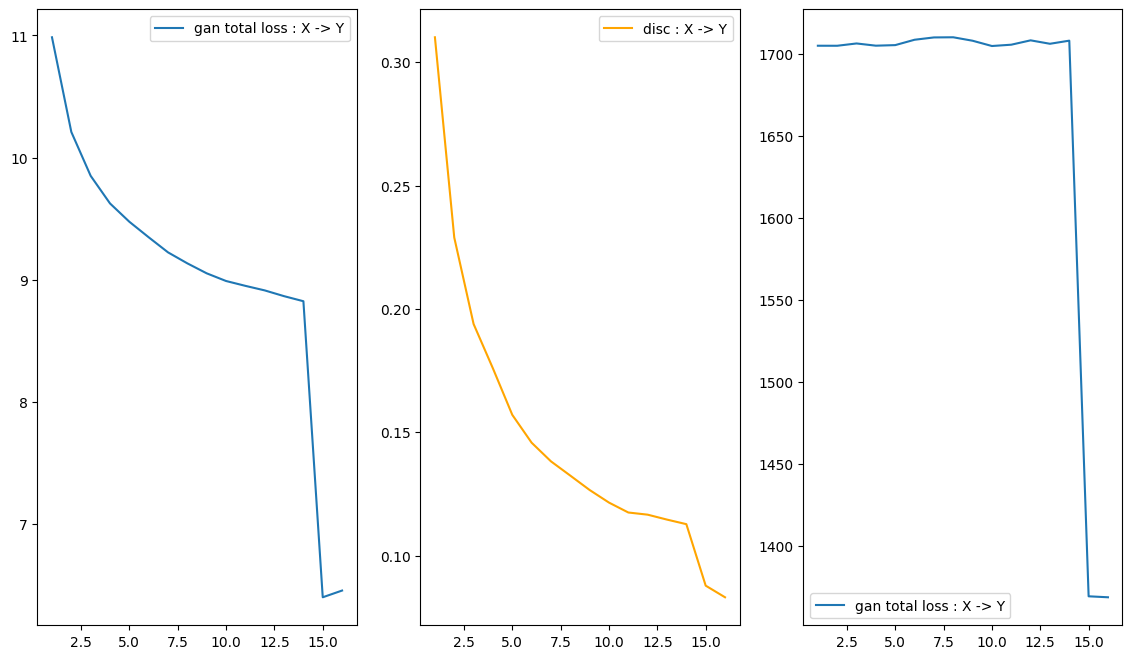

Seed :  627

Start of epoch 17


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 13102495060129563399


step 0 gen_loss : 6.98922 disc_loss : 0.07412054 Bright coef : 1.1
step 1 gen_loss : 7.2468996 disc_loss : 0.057701506 Bright coef : 0.7
step 2 gen_loss : 6.1505246 disc_loss : 0.02309369 Bright coef : 1.0199474407330027
step 3 gen_loss : 6.685792 disc_loss : 0.07434197 Bright coef : 0.7293965127737353
step 4 gen_loss : 4.3551826 disc_loss : 0.11192532 Bright coef : 1.0100727060937296
step 5 gen_loss : 7.0020885 disc_loss : 0.17281076 Bright coef : 1.1
step 6 gen_loss : 6.5060472 disc_loss : 0.1280951 Bright coef : 0.791319835932329
step 7 gen_loss : 5.034953 disc_loss : 0.14239836 Bright coef : 0.9054406258847868
step 8 gen_loss : 4.398084 disc_loss : 0.14569691 Bright coef : 0.94603246223891
step 9 gen_loss : 6.388766 disc_loss : 0.17364198 Bright coef : 0.7224556607169301
step 10 gen_loss : 4.2278247 disc_loss : 0.114038706 Bright coef : 0.8634018505209924
step 11 gen_loss : 7.673066 disc_loss : 0.048774444 Bright coef : 1.1
step 12 gen_loss : 7.1674285 disc_loss : 0.065576255 Brigh

step 105 gen_loss : 5.017474 disc_loss : 0.11676395 Bright coef : 0.8130831493224764
step 106 gen_loss : 6.1293054 disc_loss : 0.030483935 Bright coef : 0.7709414407389926
step 107 gen_loss : 8.516666 disc_loss : 0.035748284 Bright coef : 0.7
step 108 gen_loss : 8.960646 disc_loss : 0.31719816 Bright coef : 0.7
step 109 gen_loss : 5.7845335 disc_loss : 0.18490414 Bright coef : 0.7
step 110 gen_loss : 7.380823 disc_loss : 0.09163573 Bright coef : 0.975378751513806
step 111 gen_loss : 5.695676 disc_loss : 0.11778985 Bright coef : 0.915011881443237
step 112 gen_loss : 5.192576 disc_loss : 0.09677034 Bright coef : 1.0244546760176834
step 113 gen_loss : 6.6608405 disc_loss : 0.033734538 Bright coef : 1.1
step 114 gen_loss : 4.628723 disc_loss : 0.20384923 Bright coef : 1.1
step 115 gen_loss : 6.0960093 disc_loss : 0.02395786 Bright coef : 0.7
step 116 gen_loss : 7.216091 disc_loss : 0.05207295 Bright coef : 0.717448581677644
step 117 gen_loss : 6.843801 disc_loss : 0.08269206 Bright coef : 

step 206 gen_loss : 5.607488 disc_loss : 0.06669419 Bright coef : 1.0989619216697448
step 207 gen_loss : 6.343346 disc_loss : 0.22858235 Bright coef : 1.0102163661390313
step 208 gen_loss : 6.386748 disc_loss : 0.058629345 Bright coef : 0.8566425839693986
step 209 gen_loss : 7.3942003 disc_loss : 0.019859755 Bright coef : 1.0976300295781982
step 210 gen_loss : 8.028365 disc_loss : 0.06011127 Bright coef : 1.1
step 211 gen_loss : 4.9941354 disc_loss : 0.13091189 Bright coef : 0.8531120263368451
step 212 gen_loss : 6.2701735 disc_loss : 0.1889716 Bright coef : 0.9738312854959924
step 213 gen_loss : 4.7917023 disc_loss : 0.109013885 Bright coef : 0.8236421953020068
step 214 gen_loss : 6.884309 disc_loss : 0.22761247 Bright coef : 0.7
step 215 gen_loss : 5.882017 disc_loss : 0.15439104 Bright coef : 0.8860430737901211
step 216 gen_loss : 6.5763683 disc_loss : 0.09307651 Bright coef : 1.1
step 217 gen_loss : 5.7793503 disc_loss : 0.089206435 Bright coef : 0.9173396620784128
step 218 gen_los

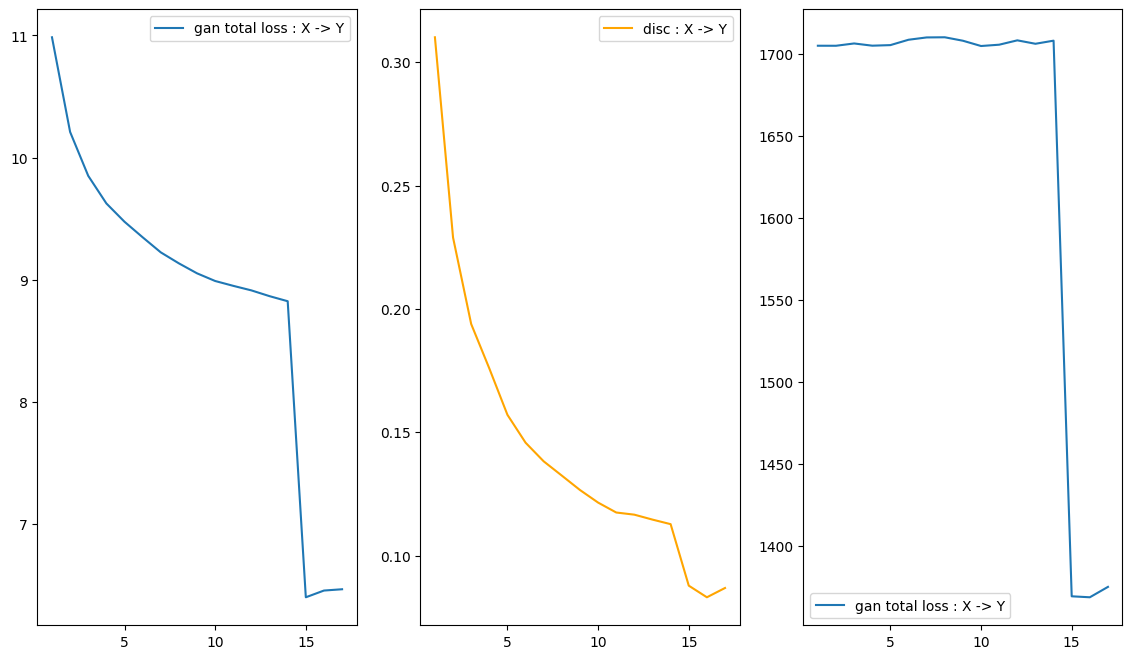

Seed :  7440

Start of epoch 18


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 13102495060129563399


step 0 gen_loss : 8.95288 disc_loss : 0.064264454 Bright coef : 1.1
step 1 gen_loss : 6.6020546 disc_loss : 0.10608063 Bright coef : 0.8807983934732824
step 2 gen_loss : 5.140028 disc_loss : 0.13572279 Bright coef : 0.7923318957124004
step 3 gen_loss : 5.3728747 disc_loss : 0.058022052 Bright coef : 0.7
step 4 gen_loss : 8.197732 disc_loss : 0.030546855 Bright coef : 1.1
step 5 gen_loss : 6.4424467 disc_loss : 0.02567966 Bright coef : 0.8568782512704423
step 6 gen_loss : 5.0431275 disc_loss : 0.074890815 Bright coef : 1.018644530431593
step 7 gen_loss : 6.619062 disc_loss : 0.10534601 Bright coef : 1.1
step 8 gen_loss : 7.221132 disc_loss : 0.15699016 Bright coef : 0.7
step 9 gen_loss : 6.6428056 disc_loss : 0.07126563 Bright coef : 1.1
step 10 gen_loss : 7.506463 disc_loss : 0.035971195 Bright coef : 1.0409317782111147
step 11 gen_loss : 6.619508 disc_loss : 0.08070365 Bright coef : 0.9288591679374427
step 12 gen_loss : 6.657459 disc_loss : 0.03904133 Bright coef : 0.7428495399080541


step 104 gen_loss : 7.4499874 disc_loss : 0.13389088 Bright coef : 0.8685434181084549
step 105 gen_loss : 4.13568 disc_loss : 0.07019754 Bright coef : 0.9965985116160089
step 106 gen_loss : 6.588445 disc_loss : 0.07911667 Bright coef : 0.7361746966814365
step 107 gen_loss : 5.2159777 disc_loss : 0.021231584 Bright coef : 0.7022855869852007
step 108 gen_loss : 5.2855577 disc_loss : 0.010398835 Bright coef : 0.9466711594466042
step 109 gen_loss : 5.714487 disc_loss : 0.01534912 Bright coef : 0.9741424459519824
step 110 gen_loss : 6.8838196 disc_loss : 0.084609166 Bright coef : 1.0280510047159048
step 111 gen_loss : 8.085926 disc_loss : 0.058076635 Bright coef : 0.7252405299448678
step 112 gen_loss : 8.152034 disc_loss : 0.0544059 Bright coef : 1.0825848314518383
step 113 gen_loss : 7.4470816 disc_loss : 0.04078175 Bright coef : 1.1
step 114 gen_loss : 8.7410555 disc_loss : 0.08606568 Bright coef : 1.073925845106094
step 115 gen_loss : 6.6331253 disc_loss : 0.079601415 Bright coef : 1.029

step 204 gen_loss : 6.3122106 disc_loss : 0.025526145 Bright coef : 0.8193604691607246
step 205 gen_loss : 6.202196 disc_loss : 0.06436272 Bright coef : 0.7005708350490283
step 206 gen_loss : 5.3192315 disc_loss : 0.093967795 Bright coef : 0.836834558272177
step 207 gen_loss : 8.065005 disc_loss : 0.054430768 Bright coef : 0.9805396709579719
step 208 gen_loss : 7.190202 disc_loss : 0.14129497 Bright coef : 0.7
step 209 gen_loss : 5.9149084 disc_loss : 0.035993084 Bright coef : 0.7
step 210 gen_loss : 6.023036 disc_loss : 0.097752765 Bright coef : 0.7
step 211 gen_loss : 6.6366973 disc_loss : 0.15543048 Bright coef : 0.7405885580182218
step 212 gen_loss : 6.0518594 disc_loss : 0.21346521 Bright coef : 0.8367578075505608
step 213 gen_loss : 5.7659817 disc_loss : 0.10435927 Bright coef : 0.7885272739610345
step 214 gen_loss : 5.2672276 disc_loss : 0.1444453 Bright coef : 0.8636994757742424
step 215 gen_loss : 6.817376 disc_loss : 0.25496525 Bright coef : 0.7636662581737
step 216 gen_loss 

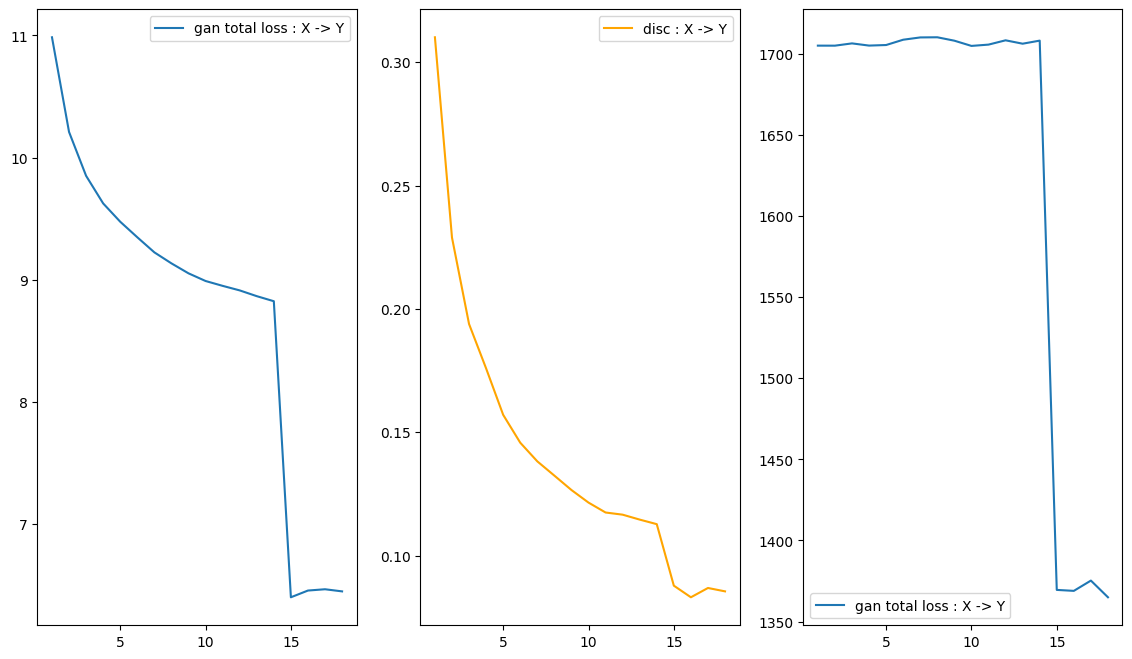

Seed :  1608

Start of epoch 19


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 13102495060129563399


step 0 gen_loss : 7.2451177 disc_loss : 0.058850452 Bright coef : 0.7169590839478991
step 1 gen_loss : 6.9841294 disc_loss : 0.052121744 Bright coef : 1.1
step 2 gen_loss : 5.4911137 disc_loss : 0.042255398 Bright coef : 0.902288744136312
step 3 gen_loss : 4.7837195 disc_loss : 0.012941888 Bright coef : 0.9727181173597303
step 4 gen_loss : 7.402693 disc_loss : 0.020922115 Bright coef : 0.9830233785846936
step 5 gen_loss : 6.583462 disc_loss : 0.052767947 Bright coef : 1.1
step 6 gen_loss : 5.3834667 disc_loss : 0.11513643 Bright coef : 0.8706186856111974
step 7 gen_loss : 6.2122283 disc_loss : 0.019259788 Bright coef : 0.7
step 8 gen_loss : 6.6579657 disc_loss : 0.013939933 Bright coef : 0.7842685952755158
step 9 gen_loss : 6.514724 disc_loss : 0.025417788 Bright coef : 0.9454525323841688
step 10 gen_loss : 5.322493 disc_loss : 0.056020528 Bright coef : 0.7
step 11 gen_loss : 6.1570077 disc_loss : 0.14406219 Bright coef : 0.912342251651652
step 12 gen_loss : 5.1431556 disc_loss : 0.092

step 103 gen_loss : 5.4304576 disc_loss : 0.1443387 Bright coef : 0.8988937308101589
step 104 gen_loss : 5.2122517 disc_loss : 0.13854185 Bright coef : 0.9702626451675589
step 105 gen_loss : 8.378504 disc_loss : 0.021353811 Bright coef : 0.7
step 106 gen_loss : 5.021112 disc_loss : 0.08248538 Bright coef : 0.8527964059028825
step 107 gen_loss : 5.645677 disc_loss : 0.03917719 Bright coef : 0.9083612142043372
step 108 gen_loss : 5.0099125 disc_loss : 0.2236825 Bright coef : 0.7
step 109 gen_loss : 5.058585 disc_loss : 0.185883 Bright coef : 0.8466988324525958
step 110 gen_loss : 7.9202666 disc_loss : 0.075144336 Bright coef : 1.1
step 111 gen_loss : 7.435374 disc_loss : 0.012130329 Bright coef : 0.7
step 112 gen_loss : 8.520728 disc_loss : 0.13731045 Bright coef : 1.1
step 113 gen_loss : 6.666304 disc_loss : 0.12481076 Bright coef : 0.9629473257390065
step 114 gen_loss : 6.373691 disc_loss : 0.026363067 Bright coef : 1.1
step 115 gen_loss : 7.3889756 disc_loss : 0.0625699 Bright coef : 

step 204 gen_loss : 4.361537 disc_loss : 0.0797879 Bright coef : 0.9519855608665974
step 205 gen_loss : 8.240063 disc_loss : 0.12325608 Bright coef : 0.7
step 206 gen_loss : 6.518471 disc_loss : 0.15518859 Bright coef : 0.9493504955724288
step 207 gen_loss : 7.40967 disc_loss : 0.07470527 Bright coef : 0.9639066373297667
step 208 gen_loss : 5.2548556 disc_loss : 0.1590876 Bright coef : 0.8634845231794366
step 209 gen_loss : 7.1554637 disc_loss : 0.285474 Bright coef : 1.1
step 210 gen_loss : 8.795015 disc_loss : 0.06327879 Bright coef : 1.1
step 211 gen_loss : 6.6213665 disc_loss : 0.07078099 Bright coef : 0.7948573605942127
step 212 gen_loss : 5.8122416 disc_loss : 0.0600955 Bright coef : 0.9087425079205512
step 213 gen_loss : 6.6883144 disc_loss : 0.025675308 Bright coef : 0.7955695550090924
step 214 gen_loss : 6.160963 disc_loss : 0.09357798 Bright coef : 1.1
step 215 gen_loss : 7.588896 disc_loss : 0.08367558 Bright coef : 1.058367031778547
step 216 gen_loss : 5.8548555 disc_loss :

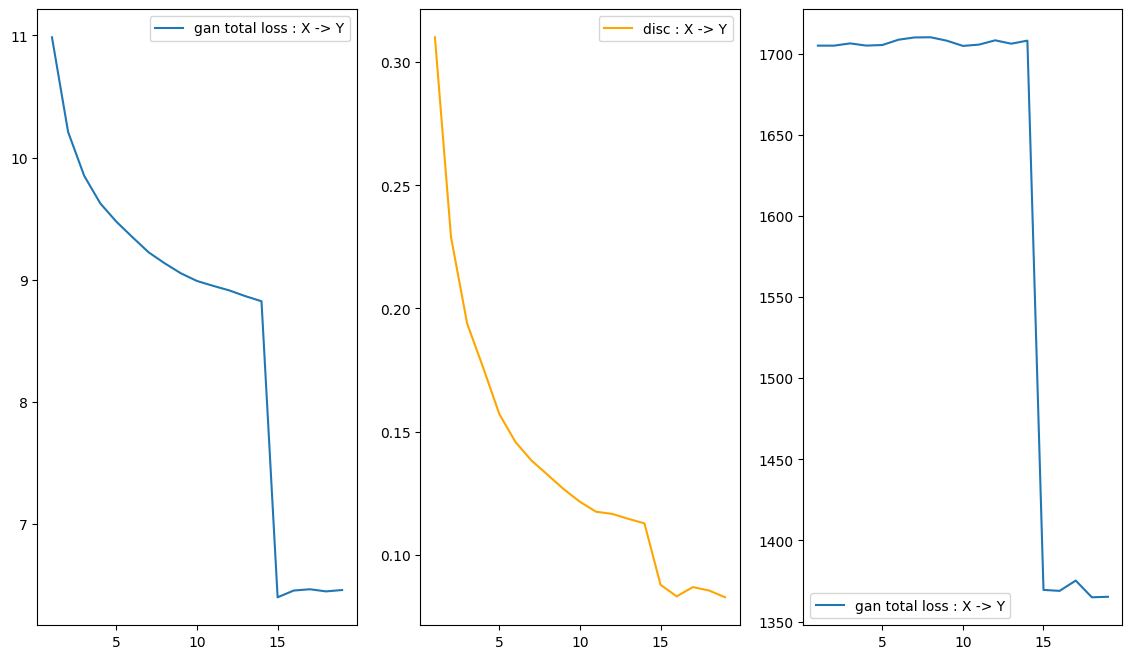

Seed :  4084

Start of epoch 20


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 13102495060129563399


step 0 gen_loss : 8.959306 disc_loss : 0.083033204 Bright coef : 1.0117515283070622
step 1 gen_loss : 9.193482 disc_loss : 0.06307476 Bright coef : 0.7851876324567841
step 2 gen_loss : 6.724967 disc_loss : 0.037322722 Bright coef : 1.040888858391548
step 3 gen_loss : 5.685966 disc_loss : 0.03257323 Bright coef : 0.8611295626310793
step 4 gen_loss : 7.242095 disc_loss : 0.0436795 Bright coef : 0.7
step 5 gen_loss : 5.2614393 disc_loss : 0.15604752 Bright coef : 0.9313855006006218
step 6 gen_loss : 5.853272 disc_loss : 0.021831369 Bright coef : 0.8966948909360851
step 7 gen_loss : 6.8929715 disc_loss : 0.032817937 Bright coef : 1.1
step 8 gen_loss : 7.0386004 disc_loss : 0.0379537 Bright coef : 1.1
step 9 gen_loss : 7.4500704 disc_loss : 0.025738183 Bright coef : 0.7331792710102261
step 10 gen_loss : 6.7502723 disc_loss : 0.017324334 Bright coef : 1.0950353972386586
step 11 gen_loss : 7.617387 disc_loss : 0.0085134 Bright coef : 0.786283359012907
step 12 gen_loss : 7.958351 disc_loss : 0

step 102 gen_loss : 7.934226 disc_loss : 0.039955754 Bright coef : 0.7
step 103 gen_loss : 6.677063 disc_loss : 0.012326673 Bright coef : 0.9871825149791165
step 104 gen_loss : 6.5178556 disc_loss : 0.05743215 Bright coef : 1.1
step 105 gen_loss : 9.166699 disc_loss : 0.011742454 Bright coef : 1.1
step 106 gen_loss : 8.428675 disc_loss : 0.026817406 Bright coef : 0.7
step 107 gen_loss : 7.1946583 disc_loss : 0.014532496 Bright coef : 0.9543917751691328
step 108 gen_loss : 5.228889 disc_loss : 0.031880148 Bright coef : 0.7762329008328536
step 109 gen_loss : 6.424497 disc_loss : 0.009933944 Bright coef : 0.812333784988331
step 110 gen_loss : 6.876588 disc_loss : 0.015037211 Bright coef : 1.1
step 111 gen_loss : 6.199304 disc_loss : 0.009715636 Bright coef : 0.9104678019314634
step 112 gen_loss : 5.8074703 disc_loss : 0.040117577 Bright coef : 0.915736956097785
step 113 gen_loss : 5.447706 disc_loss : 0.15211625 Bright coef : 0.8647620893938379
step 114 gen_loss : 7.553628 disc_loss : 0.0

step 203 gen_loss : 6.113823 disc_loss : 0.031092627 Bright coef : 0.7457555179529217
step 204 gen_loss : 4.0438423 disc_loss : 0.052090578 Bright coef : 0.8214495354474046
step 205 gen_loss : 6.324318 disc_loss : 0.07684743 Bright coef : 0.8347582359292051
step 206 gen_loss : 7.0829983 disc_loss : 0.048701487 Bright coef : 1.0915625071531514
step 207 gen_loss : 4.4454126 disc_loss : 0.07161507 Bright coef : 0.9375277575956182
step 208 gen_loss : 5.1034064 disc_loss : 0.03967596 Bright coef : 1.1
step 209 gen_loss : 5.7517567 disc_loss : 0.023653535 Bright coef : 1.0819272932925823
step 210 gen_loss : 6.514795 disc_loss : 0.07940802 Bright coef : 0.9415694627631024
step 211 gen_loss : 6.027186 disc_loss : 0.12735185 Bright coef : 0.8369571537419457
step 212 gen_loss : 9.265188 disc_loss : 0.036204416 Bright coef : 1.1
step 213 gen_loss : 5.886926 disc_loss : 0.029418088 Bright coef : 0.8502248204113004
step 214 gen_loss : 4.8293076 disc_loss : 0.18431216 Bright coef : 0.918425036033601

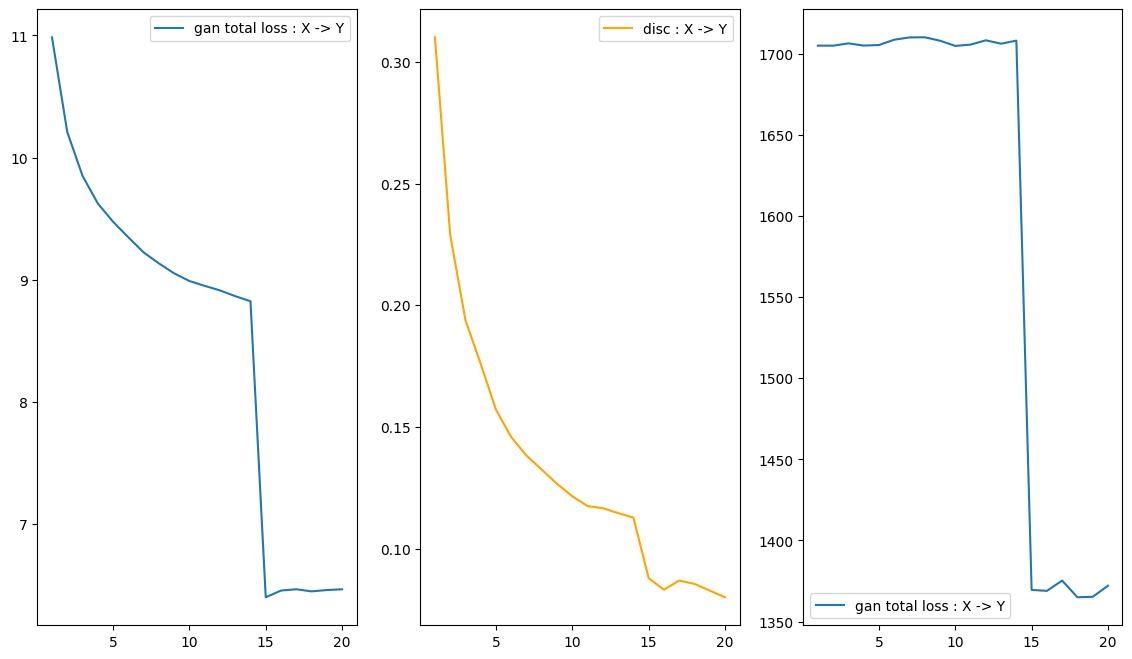

Seed :  238

Start of epoch 21


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 13102495060129563399


step 0 gen_loss : 8.441402 disc_loss : 0.018243626 Bright coef : 1.0904650143092798
step 1 gen_loss : 5.4310956 disc_loss : 0.08747355 Bright coef : 0.932065462907031
step 2 gen_loss : 6.034466 disc_loss : 0.15804608 Bright coef : 0.7278812145939145
step 3 gen_loss : 6.216269 disc_loss : 0.09882241 Bright coef : 0.7
step 4 gen_loss : 7.6743784 disc_loss : 0.026800713 Bright coef : 0.7
step 5 gen_loss : 6.746792 disc_loss : 0.12226004 Bright coef : 1.0840720239195007
step 6 gen_loss : 5.9352484 disc_loss : 0.07979137 Bright coef : 0.8431795575703945
step 7 gen_loss : 5.6176176 disc_loss : 0.107273065 Bright coef : 1.1
step 8 gen_loss : 7.301202 disc_loss : 0.05034694 Bright coef : 0.7177029101335413
step 9 gen_loss : 5.3268228 disc_loss : 0.06885703 Bright coef : 0.7
step 10 gen_loss : 5.6242633 disc_loss : 0.122782916 Bright coef : 1.1
step 11 gen_loss : 6.8796763 disc_loss : 0.027757429 Bright coef : 1.1
step 12 gen_loss : 8.542412 disc_loss : 0.078427345 Bright coef : 0.7
step 13 gen

step 104 gen_loss : 6.3826723 disc_loss : 0.11262481 Bright coef : 1.0503323124327852
step 105 gen_loss : 6.7454047 disc_loss : 0.04573279 Bright coef : 0.9141141350496375
step 106 gen_loss : 5.6048474 disc_loss : 0.016319947 Bright coef : 0.8172786172131878
step 107 gen_loss : 5.226856 disc_loss : 0.22077908 Bright coef : 1.0618163332548995
step 108 gen_loss : 7.265718 disc_loss : 0.10682349 Bright coef : 0.9353225983692738
step 109 gen_loss : 8.970553 disc_loss : 0.039379463 Bright coef : 0.7564420183786025
step 110 gen_loss : 6.7578406 disc_loss : 0.09803384 Bright coef : 1.1
step 111 gen_loss : 5.443358 disc_loss : 0.113856845 Bright coef : 0.9943852371951796
step 112 gen_loss : 7.8787603 disc_loss : 0.018020771 Bright coef : 0.7
step 113 gen_loss : 5.333038 disc_loss : 0.10199584 Bright coef : 0.8183165167391633
step 114 gen_loss : 5.5279593 disc_loss : 0.08160909 Bright coef : 0.859207620657728
step 115 gen_loss : 7.404987 disc_loss : 0.06398434 Bright coef : 0.7
step 116 gen_los

step 205 gen_loss : 9.593007 disc_loss : 0.3989319 Bright coef : 0.7277523942905393
step 206 gen_loss : 8.452948 disc_loss : 0.13753167 Bright coef : 0.9405351403176145
step 207 gen_loss : 5.791465 disc_loss : 0.2373072 Bright coef : 0.9568767788650328
step 208 gen_loss : 5.7781863 disc_loss : 0.055018153 Bright coef : 0.7323491706481232
step 209 gen_loss : 5.491281 disc_loss : 0.07701388 Bright coef : 0.7799336111394999
step 210 gen_loss : 4.118659 disc_loss : 0.22910249 Bright coef : 0.7944714205973666
step 211 gen_loss : 4.6452975 disc_loss : 0.030417677 Bright coef : 0.9302957048395382
step 212 gen_loss : 5.748626 disc_loss : 0.05416714 Bright coef : 0.9600432817811706
step 213 gen_loss : 5.1155024 disc_loss : 0.12714557 Bright coef : 1.1
step 214 gen_loss : 8.589796 disc_loss : 0.036573846 Bright coef : 1.1
step 215 gen_loss : 7.8251977 disc_loss : 0.05283303 Bright coef : 1.1
step 216 gen_loss : 6.422661 disc_loss : 0.037235208 Bright coef : 0.8021912583810002
step 217 gen_loss :

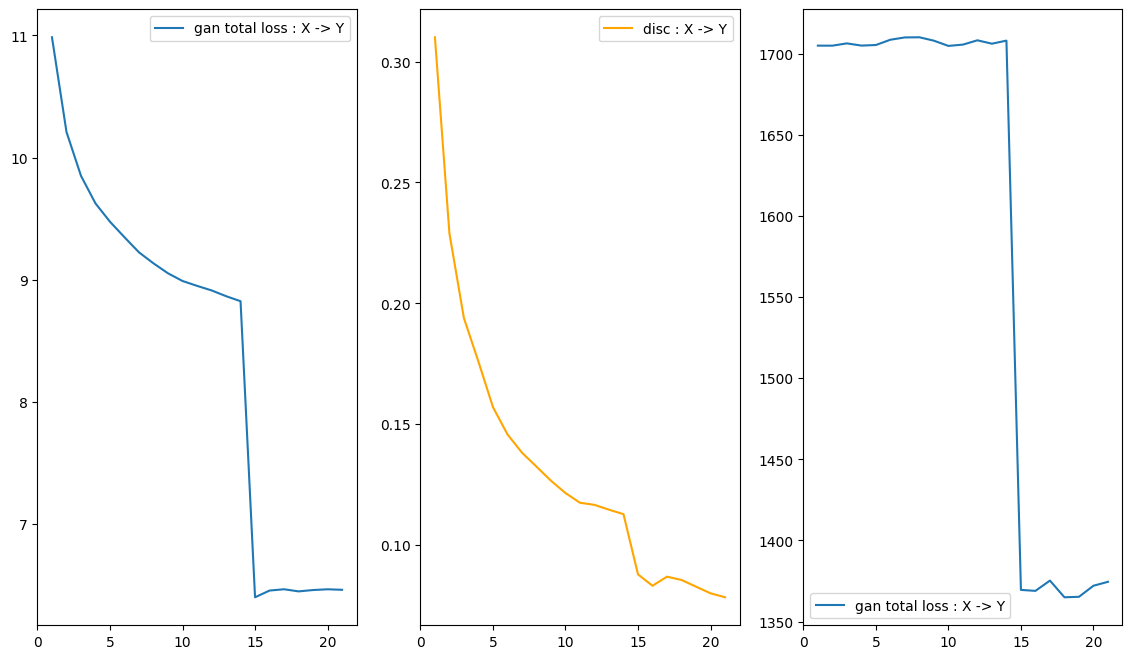

Seed :  3826

Start of epoch 22


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 13102495060129563399


step 0 gen_loss : 5.3990173 disc_loss : 0.047582794 Bright coef : 0.7880445636521181
step 1 gen_loss : 6.296571 disc_loss : 0.2773717 Bright coef : 1.1
step 2 gen_loss : 5.6024113 disc_loss : 0.062794454 Bright coef : 1.0529340711909518
step 3 gen_loss : 6.609979 disc_loss : 0.025454454 Bright coef : 1.093033886463262
step 4 gen_loss : 6.7029495 disc_loss : 0.084919065 Bright coef : 1.1
step 5 gen_loss : 6.8931937 disc_loss : 0.020215733 Bright coef : 0.8663508810069876
step 6 gen_loss : 6.110698 disc_loss : 0.038085543 Bright coef : 1.05391116404046
step 7 gen_loss : 9.383026 disc_loss : 0.0840457 Bright coef : 1.1
step 8 gen_loss : 6.0500603 disc_loss : 0.035336506 Bright coef : 0.7
step 9 gen_loss : 5.1828046 disc_loss : 0.09210752 Bright coef : 0.8983839292164543
step 10 gen_loss : 8.594463 disc_loss : 0.03801433 Bright coef : 0.7
step 11 gen_loss : 6.9455333 disc_loss : 0.23718517 Bright coef : 1.0048786356181072
step 12 gen_loss : 6.880954 disc_loss : 0.14039993 Bright coef : 0.7

step 102 gen_loss : 6.472659 disc_loss : 0.18964048 Bright coef : 1.0201356183679775
step 103 gen_loss : 5.7588387 disc_loss : 0.08232706 Bright coef : 1.0213344108348554
step 104 gen_loss : 8.286135 disc_loss : 0.033980027 Bright coef : 1.0449949689187208
step 105 gen_loss : 8.373737 disc_loss : 0.046890076 Bright coef : 0.7203362972915593
step 106 gen_loss : 4.831039 disc_loss : 0.033776667 Bright coef : 0.9923605306107636
step 107 gen_loss : 7.2704825 disc_loss : 0.032777663 Bright coef : 0.7185926541369041
step 108 gen_loss : 8.262374 disc_loss : 0.074421704 Bright coef : 0.9686607499501689
step 109 gen_loss : 7.0331087 disc_loss : 0.025705071 Bright coef : 0.7
step 110 gen_loss : 7.516858 disc_loss : 0.014789099 Bright coef : 0.7
step 111 gen_loss : 5.332666 disc_loss : 0.12172778 Bright coef : 1.1
step 112 gen_loss : 8.88213 disc_loss : 0.070861205 Bright coef : 0.8857812159065619
step 113 gen_loss : 5.232081 disc_loss : 0.021268185 Bright coef : 0.9226985424762568
step 114 gen_l

step 204 gen_loss : 8.379747 disc_loss : 0.06280074 Bright coef : 0.7117022258191568
step 205 gen_loss : 4.8170877 disc_loss : 0.036026347 Bright coef : 0.8090453809470338
step 206 gen_loss : 6.9126954 disc_loss : 0.046688776 Bright coef : 0.7
step 207 gen_loss : 5.334523 disc_loss : 0.04097089 Bright coef : 0.9437194184601136
step 208 gen_loss : 5.96204 disc_loss : 0.058479905 Bright coef : 0.8178306968088147
step 209 gen_loss : 7.621092 disc_loss : 0.02408776 Bright coef : 0.7
step 210 gen_loss : 6.7789474 disc_loss : 0.0912203 Bright coef : 1.1
step 211 gen_loss : 5.8688545 disc_loss : 0.07830042 Bright coef : 0.7721126103262319
step 212 gen_loss : 5.2963867 disc_loss : 0.03839803 Bright coef : 0.9874751186828205
step 213 gen_loss : 6.533739 disc_loss : 0.02909531 Bright coef : 0.7973414804946513
step 214 gen_loss : 7.0719323 disc_loss : 0.05417397 Bright coef : 0.7
step 215 gen_loss : 5.5075483 disc_loss : 0.06567097 Bright coef : 0.9958857524251215
step 216 gen_loss : 9.533739 dis

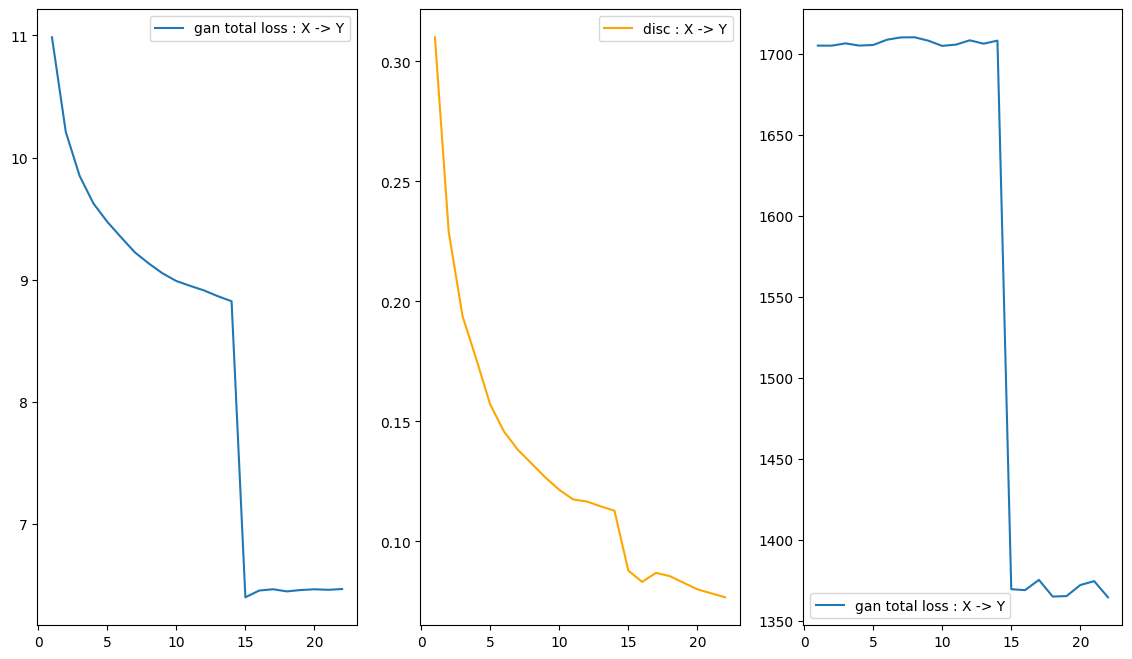

Seed :  4896

Start of epoch 23


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 13102495060129563399


step 0 gen_loss : 6.868085 disc_loss : 0.11855455 Bright coef : 1.068961566716023
step 1 gen_loss : 6.393006 disc_loss : 0.032399405 Bright coef : 0.7476903592575767
step 2 gen_loss : 7.4041243 disc_loss : 0.026124407 Bright coef : 0.9899971994062801
step 3 gen_loss : 5.992989 disc_loss : 0.026427614 Bright coef : 0.7995253272000813
step 4 gen_loss : 7.7354407 disc_loss : 0.038491346 Bright coef : 0.9180532133367063
step 5 gen_loss : 7.928475 disc_loss : 0.09213546 Bright coef : 1.0812175538473463
step 6 gen_loss : 5.748806 disc_loss : 0.019868985 Bright coef : 1.1
step 7 gen_loss : 4.425832 disc_loss : 0.018808044 Bright coef : 0.9761325031661479
step 8 gen_loss : 6.121604 disc_loss : 0.12612124 Bright coef : 1.1
step 9 gen_loss : 6.1757584 disc_loss : 0.081063226 Bright coef : 0.8629769007946045
step 10 gen_loss : 6.420872 disc_loss : 0.069213785 Bright coef : 0.7924220198310755
step 11 gen_loss : 6.8397107 disc_loss : 0.014684718 Bright coef : 0.8700935946966111
step 12 gen_loss : 6

step 103 gen_loss : 6.7211013 disc_loss : 0.071984895 Bright coef : 0.8582955156381851
step 104 gen_loss : 5.614272 disc_loss : 0.08633212 Bright coef : 1.0045643701442653
step 105 gen_loss : 8.550006 disc_loss : 0.023139574 Bright coef : 0.7170460766284651
step 106 gen_loss : 7.5232353 disc_loss : 0.070268944 Bright coef : 1.0192883459251063
step 107 gen_loss : 6.736199 disc_loss : 0.03720913 Bright coef : 0.7
step 108 gen_loss : 7.0394216 disc_loss : 0.18934283 Bright coef : 0.9737561268212835
step 109 gen_loss : 8.247425 disc_loss : 0.016872693 Bright coef : 0.971525670984684
step 110 gen_loss : 6.539093 disc_loss : 0.018450268 Bright coef : 1.058559827165234
step 111 gen_loss : 5.723666 disc_loss : 0.018287836 Bright coef : 0.9273939401640531
step 112 gen_loss : 6.3202753 disc_loss : 0.04408156 Bright coef : 0.8840063736376389
step 113 gen_loss : 6.013725 disc_loss : 0.12216536 Bright coef : 0.8526558926598433
step 114 gen_loss : 8.331278 disc_loss : 0.11744215 Bright coef : 0.9847

step 204 gen_loss : 7.4238935 disc_loss : 0.028435476 Bright coef : 1.1
step 205 gen_loss : 5.3701677 disc_loss : 0.018460417 Bright coef : 1.022371267723066
step 206 gen_loss : 5.925773 disc_loss : 0.11851737 Bright coef : 0.8902500226489298
step 207 gen_loss : 5.7420025 disc_loss : 0.038120218 Bright coef : 0.9578359794187989
step 208 gen_loss : 5.6684003 disc_loss : 0.120364994 Bright coef : 0.8607789522290732
step 209 gen_loss : 9.633547 disc_loss : 0.07012905 Bright coef : 1.1
step 210 gen_loss : 6.1820297 disc_loss : 0.018832166 Bright coef : 0.8082783806883175
step 211 gen_loss : 5.8922787 disc_loss : 0.03790022 Bright coef : 0.8887932628278041
step 212 gen_loss : 7.070095 disc_loss : 0.010947035 Bright coef : 0.7
step 213 gen_loss : 5.294621 disc_loss : 0.03967528 Bright coef : 0.7070891505652629
step 214 gen_loss : 7.684964 disc_loss : 0.052006137 Bright coef : 0.956341843059979
step 215 gen_loss : 7.9550986 disc_loss : 0.061071187 Bright coef : 1.1
step 216 gen_loss : 8.89477

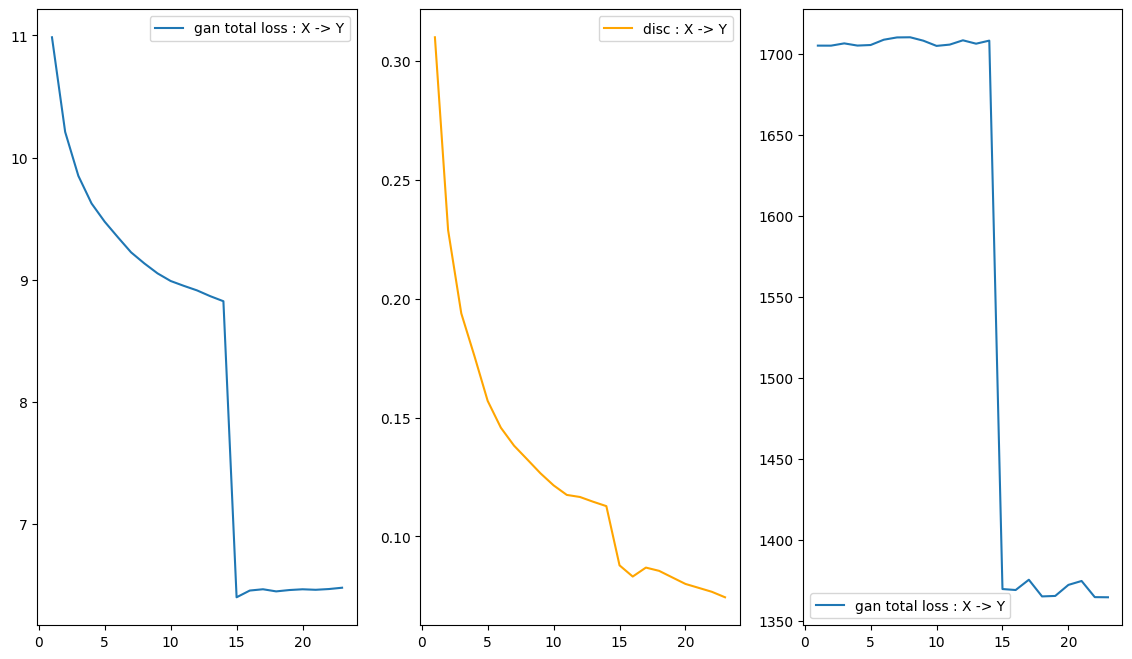

Seed :  4349

Start of epoch 24


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 13102495060129563399


step 0 gen_loss : 8.024324 disc_loss : 0.03741639 Bright coef : 0.7
step 1 gen_loss : 6.1198883 disc_loss : 0.040599726 Bright coef : 0.8104868081254544
step 2 gen_loss : 9.855384 disc_loss : 0.013589167 Bright coef : 1.1
step 3 gen_loss : 6.3529415 disc_loss : 0.017440185 Bright coef : 1.1
step 4 gen_loss : 8.067811 disc_loss : 0.031088868 Bright coef : 0.7840461197320984
step 5 gen_loss : 5.923282 disc_loss : 0.0149841495 Bright coef : 0.9522966098944443
step 6 gen_loss : 4.8078303 disc_loss : 0.074204616 Bright coef : 1.1
step 7 gen_loss : 6.4484267 disc_loss : 0.068303645 Bright coef : 0.7
step 8 gen_loss : 6.363097 disc_loss : 0.018782692 Bright coef : 0.7902459104115842
step 9 gen_loss : 4.5876436 disc_loss : 0.053408343 Bright coef : 0.9426579564594386
step 10 gen_loss : 5.88816 disc_loss : 0.06633626 Bright coef : 1.0765552097573758
step 11 gen_loss : 7.8642845 disc_loss : 0.037972756 Bright coef : 0.9411477397137223
step 12 gen_loss : 8.402509 disc_loss : 0.07664199 Bright coe

KeyboardInterrupt: 

In [8]:
# Test Path
path_test = 'test/test_set/test_set_Urban_Launcher_256'
# Save path
save_model = 'save_models/VResnet/VOK/'
save_loss = 'loss/VResnet/VOK/'
#load
#generator.load_weights(save_model+'gen_model_color_epoch_5.h5')
#discriminator.load_weights(save_model+'dis_model_color_epoch_5.h5')
DISC_X=tf.keras.saving.load_model('./save_models/VResnet/VOK/save_resnet_DX_14')
DISC_Y=tf.keras.saving.load_model('./save_models/VResnet/VOK/save_resnet_DY_14')
GEN_Y=tf.keras.saving.load_model('./save_models/VResnet/VOK/save_resnet_GY_14')
GEN_X=tf.keras.saving.load_model('./save_models/VResnet/VOK/save_resnet_GX_14')

EPOCHS_START=15
EPOCHS = 200
BATCH_SIZE=2
LR_G = LR_D = 2e-4
print("Learning Rate G : "+str(LR_G)+" Learning Rate D : "+str(LR_D))
#GEN_X_optimizer = tf.keras.optimizers.Adam(LR_G, beta_1=0.5)    #2e-4
#DISC_X_optimizer = tf.keras.optimizers.Adam(LR_D, beta_1=0.5)  #2e-4

#GEN_Y_optimizer = tf.keras.optimizers.Adam(LR_G, beta_1=0.5)    #2e-4
#DISC_Y_optimizer = tf.keras.optimizers.Adam(LR_D, beta_1=0.5)  #2e-4
#
GLoss=[]
DLoss=[]
#
# Load dataset 
Dataset = tf.data.Dataset.load('./Dataset_wo_sky_256/V_Urban_Launcher/Dataset_VUL')
#
if EPOCHS_START!=1:
    #load loss
    GLoss_Epochs = list(np.load(save_loss+'Gloss_mean_14.npy')[0:EPOCHS_START])
    DLoss_Epochs = list(np.load(save_loss+'Dloss_mean_14.npy')[0:EPOCHS_START])
    TLoss_Epochs = list(np.load(save_loss+'Tloss_mean_14.npy')[0:EPOCHS_START])
    #TLoss_L1_Epochs = list(np.load(save_loss+'Tloss_L1_mean_26.npy')[0:EPOCHS_START])
else:
    GLoss_Epochs=[]
    DLoss_Epochs=[]
    TLoss_Epochs=[]
    #TLoss_L1_Epochs=[]
#
for i in range(EPOCHS_START,EPOCHS+1):
    #
    SEED = random.randint(0,10000)
    print('Seed : ',SEED)
    # SHUFFLE AND BATCH
    #Dataset_X = shuffle_and_batch(Dataset[0], 40, SEED)
    Dataset_B = shuffle_and_batch(Dataset, 40, SEED)
    #
    #for j,L in enumerate(Dataset_B):
    #    print('dataset_'+str(j)+' saved', tf.shape(L))
    #print(j)
    print("\nStart of epoch %d" % (i,))
    #
    # train model
    (D,G, GEN_X, DISC_X, GEN_Y, DISC_Y)=train(GEN_X, DISC_X, GEN_Y, DISC_Y, Dataset_B, batch=BATCH_SIZE)
    GLoss.append(np.mean(G))
    DLoss.append(np.mean(D))
        
    GLoss_Epochs.append(np.mean(GLoss))
    DLoss_Epochs.append(np.mean(DLoss))
            
    DISC_X.save_weights(save_model+'disX_model_color_epoch_'+str(i)+'.h5')
    GEN_X.save_weights(save_model+'genX_model_color_epoch_'+str(i)+'.h5')
    DISC_Y.save_weights(save_model+'disY_model_color_epoch_'+str(i)+'.h5')
    GEN_Y.save_weights(save_model+'genY_model_color_epoch_'+str(i)+'.h5')
        
    # test loss
    AVG = test_loss_avg(GEN_X,DISC_Y,path_test)
    TLoss_Epochs.append(AVG)
    #TLoss_L1_Epochs.append(L1)
    # Save loss
    np.save(save_loss+'Dloss_mean_'+str(i)+'.npy',DLoss_Epochs)
    np.save(save_loss+'Gloss_mean_'+str(i)+'.npy',GLoss_Epochs)
    np.save(save_loss+'Tloss_mean_'+str(i)+'.npy',TLoss_Epochs)
    #np.save(save_loss+'Tloss_L1_mean_'+str(i)+'.npy',TLoss_L1_Epochs)
    
    X_EPOCHS = np.arange(1,i+1, 1)
    
    print('X : ',X_EPOCHS)
    print('G : ',GLoss_Epochs)
    print('D : ',DLoss_Epochs)
    print('T_avg : ',TLoss_Epochs)
    #print('T_L1 : ',TLoss_L1_Epochs)
    #print('C : ',CLoss_Epochs)

    plt.figure(figsize=(14,8))
    plt.subplot(1, 3, 1)
    plt.plot(X_EPOCHS, GLoss_Epochs, label='gan total loss : X -> Y')
    plt.legend()
    plt.subplot(1, 3, 2)
    plt.plot(X_EPOCHS, DLoss_Epochs,'orange', label='disc : X -> Y')
    plt.legend()
    plt.subplot(1, 3, 3)
    plt.plot(X_EPOCHS, np.array(TLoss_Epochs), label='gan total loss : X -> Y')
    plt.legend()
    #
    if (i%5 == 0):
        plt.savefig(save_loss+'Loss_'+str(i)+'.png')
        print('Saved')   
    plt.show()             

# save models
print("gan_model")

In [9]:
tf.keras.saving.save_model(DISC_X,'./save_models/VResnet/VOK/save_resnet_DX_24')
tf.keras.saving.save_model(DISC_Y,'./save_models/VResnet/VOK/save_resnet_DY_24')
tf.keras.saving.save_model(GEN_Y,'./save_models/VResnet/VOK/save_resnet_GY_24')
tf.keras.saving.save_model(GEN_X,'./save_models/VResnet/VOK/save_resnet_GX_24')

INFO:tensorflow:Assets written to: ./save_models/VResnet/VOK/save_resnet_DX_24/assets


INFO:tensorflow:Assets written to: ./save_models/VResnet/VOK/save_resnet_DX_24/assets


INFO:tensorflow:Assets written to: ./save_models/VResnet/VOK/save_resnet_DY_24/assets


INFO:tensorflow:Assets written to: ./save_models/VResnet/VOK/save_resnet_DY_24/assets


INFO:tensorflow:Assets written to: ./save_models/VResnet/VOK/save_resnet_GY_24/assets


INFO:tensorflow:Assets written to: ./save_models/VResnet/VOK/save_resnet_GY_24/assets


INFO:tensorflow:Assets written to: ./save_models/VResnet/VOK/save_resnet_GX_24/assets


INFO:tensorflow:Assets written to: ./save_models/VResnet/VOK/save_resnet_GX_24/assets


In [22]:
# try on a test image
import cv2
from tensorflow import keras
import numpy as np

save_models = 'save_models/VResnet/'
image_shape=(512,512,3)

num = 28

# define the models
generator = define_generator(image_shape,6)
#load initial weights
generator.load_weights(save_models+'genX_model_color_epoch_'+str(num)+'.h5') #4,5,13,25 

doss_image = 'test/val_set/org'
doss_gen = 'test/val_set/V_Urban_Launcher/V3/gen_'+str(num)  #V17/gen_50'
#doss_image ='dataset_color_transfer/test_sans_batch/V5_dts/new'
#doss_gen = 'dataset_color_transfer/test_sans_batch/V5_dts/old'

IMAGE=os.listdir(doss_image)
IMAGE.sort()

for file in IMAGE:
    old = os.path.join(doss_image,file)
    new = os.path.join(doss_gen,file+'_CGAN_'+str(num)+'.jpg') 
    #new = os.path.join(doss_gen,file) 
    X1=[]
    # now read the input image files (difference from the code it is derived from that preloads all images)
    pixels = Image.open(old).convert("RGB")
    pixels = np.array(pixels)
    pixels = pixels[np.newaxis, ...]
    #
    img_fake = generator(pixels, training=False)
    print(tf.shape(img_fake))
    img_fake = img_fake[0].numpy() * 127.5 + 127.5
    print(img_fake)
    img_fake= img_fake.astype(np.uint8)
    print(img_fake.shape)
    image_reco=Image.fromarray(img_fake)
    #image_reco.show()
    #cv2.imwrite('test/image_00000168_gan_color.png',img.astype(int))
    image_reco = image_reco.save(new)

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 tf.compat.v1.pad_28 (TFOpL  (None, 516, 516, 3)          0         ['input_10[0][0]']            
 ambda)                                                                                           
                                                                                                  
 conv2d_124 (Conv2D)         (None, 512, 512, 64)         4864      ['tf.compat.v1.pad_28[0][0]'] 
                                                                                                  
 batch_normalization_134 (B  (None, 512, 512, 64)         256       ['conv2d_124[0][0]']    

 atchNormalization)                                                                               
                                                                                                  
 concatenate_30264 (Concate  (None, 128, 128, 1024)       0         ['batch_normalization_142[0][0
 nate)                                                              ]',                           
                                                                     'concatenate_30263[0][0]']   
                                                                                                  
 conv2d_133 (Conv2D)         (None, 128, 128, 256)        2359552   ['concatenate_30264[0][0]']   
                                                                                                  
 batch_normalization_143 (B  (None, 128, 128, 256)        1024      ['conv2d_133[0][0]']          
 atchNormalization)                                                                               
          

 activation_95 (Activation)  (None, 512, 512, 3)          0         ['batch_normalization_151[0][0
                                                                    ]']                           
                                                                                                  
Total params: 18460175 (70.42 MB)
Trainable params: 18452745 (70.39 MB)
Non-trainable params: 7430 (29.02 KB)
__________________________________________________________________________________________________


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'save_models/VResnet/genX_model_color_epoch_28.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

**Source**

https://github.com/soumith/ganhacks/issues/14
https://www.inference.vc/instance-noise-a-trick-for-stabilising-gan-training/

I think the discriminator got too strong relative to the generator. Beyond this point, the generator finds it almost impossible to fool the discriminator, hence the increase in it's loss. I'm facing a similar problem.

Probably, the problem is that the discriminator overfit. One of the reasons leading to this is following thing:
discriminator may "notice" that images from true distribution is a matrix of numbers of the form n/255. So, adding gaussian noise to the input images may help to avoid the problem.
It helps in my case.

Probably, the problem is that the discriminator overfit. One of the reasons leading to this is following thing:
discriminator may "notice" that images from true distribution is a matrix of numbers of the form n/255. So, adding gaussian noise to the input images may help to avoid the problem.
It helps in my case.

https://imatge.upc.edu/web/sites/default/files/pub/xTarres21.pdf

Dropout :
https://saturncloud.io/blog/how-to-properly-use-dropout-in-tensorflow-a-guide-for-data-scientists/

Filters :
https://datascience.stackexchange.com/questions/55545/in-cnn-why-do-we-increase-the-number-of-filters-in-deeper-convolution-layers-fo

Loss study :
https://arxiv.org/pdf/2204.02980.pdf

http://cs231n.stanford.edu/reports/2017/pdfs/302.pdf

https://arxiv.org/pdf/1703.10593.pdf

https://arxiv.org/pdf/1603.08511.pdf



Training indicating whether the layer should behave in training mode or in inference mode.

    training=True: The layer will normalize its inputs using the mean and variance of the current batch of inputs.

    training=False: The layer will normalize its inputs using the mean and variance of its moving statistics, learned during training.

Usually in inference mode training=False, but in some networks such as pix2pix_cGAN‍‍‍‍‍‍ At both times of inference and training, training=True.

Seed counter tf : https://saturncloud.io/blog/tensorflow-different-results-with-the-same-random-seed/


**CYCLE GAN :** 

https://www.tensorflow.org/tutorials/generative/cyclegan

https://arxiv.org/pdf/1703.10593.pdf

https://github.com/simontomaskarlsson/CycleGAN-Keras/blob/master/model.py


In [ ]:
# Save optimizer weights
#symbolic_weights = getattr(discriminator.optimizer, 'weights')
#weight_values = K.batch_get_value(symbolic_weights)  # or symbolic_weights.numpy()
# Then store .npy
#
# Load optimizer weights
#weight_values = np.load(...)
#model.optimizer.set_weights(weight_values)